# Exploring Different Fitness / Selection Criterion

Goal 1: Implement surviving parents alongside reproducing population. Up until now, we have been selecting genes at random from the best 50% of the population. So the next generation was all children with an amalgam of genes from the parent generation. Now we will implement survivors. These are solutions in our population who not only have the opportunity to reproduce, but they will survive intact to the next generation. This will be a small subsample of the best of the best in out population maybe the top 10%. 

Goal 2: Test different ratios for the reproducing population and carryover population. Default is use the best 50% to reproduce and 10% to survive, what do other ratios look like? Which one works best/should we use for our model? How does this affect diversity vs accuracy?

Goal 3: Implement the "low-ranking chimp." In hierarchical chimpanzee society, it is mainly the "Alpha" males who mate with the females of the group. However, the lower ranking males do, on occasion reproduce too. I think it would be interesting to see if implementing a low probability chance that one or several of the lowest ranking individuals pass on their genes would affect the model. I predict that it will be some sort of 

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')  # Replace '/path/to/EVO_BASE' with the actual path to the module
from EVO import LogisticRegression, EvolutionOptimizer
from fitness import FitnessOptimizer
import torch
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

In [4]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    return (y_pred == y).float().mean().item()

In [7]:
X, y = classification_data(p_dims=200, noise=0.2, n_points=100)
LR = LogisticRegression()
opt = FitnessOptimizer(LR, "cuda")
opt.set_mutation_rate(0.5)
opt.set_population_size(100)

LR.set_optimizer(opt)

loss = []
start = time.time()
while accuracy(LR, X, y) < 1:
    opt.step(X, y, fitness_threshold=2)
    loss.append(LR.loss(X, y).item())
print("Time taken: ", time.time() - start)
plt.plot(loss, label="Evolution Optimizer Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer")
plt.legend()
plt.grid(True)
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat in method wrapper_CUDA_addmv_)

RunTimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat in method wrapper_CUDA_addmv_)

Running for thresh = 2
Finished in 30 iterations, Time: 608.34s
Running for thresh = 3
Finished in 23 iterations, Time: 480.15s
Running for thresh = 4
Finished in 22 iterations, Time: 501.95s
Running for thresh = 5
Finished in 24 iterations, Time: 524.32s
Running for thresh = 6
Finished in 18 iterations, Time: 398.57s
Running for thresh = 7
Finished in 18 iterations, Time: 390.42s
Running for thresh = 8
Finished in 20 iterations, Time: 370.52s
Running for thresh = 9
Finished in 21 iterations, Time: 394.13s


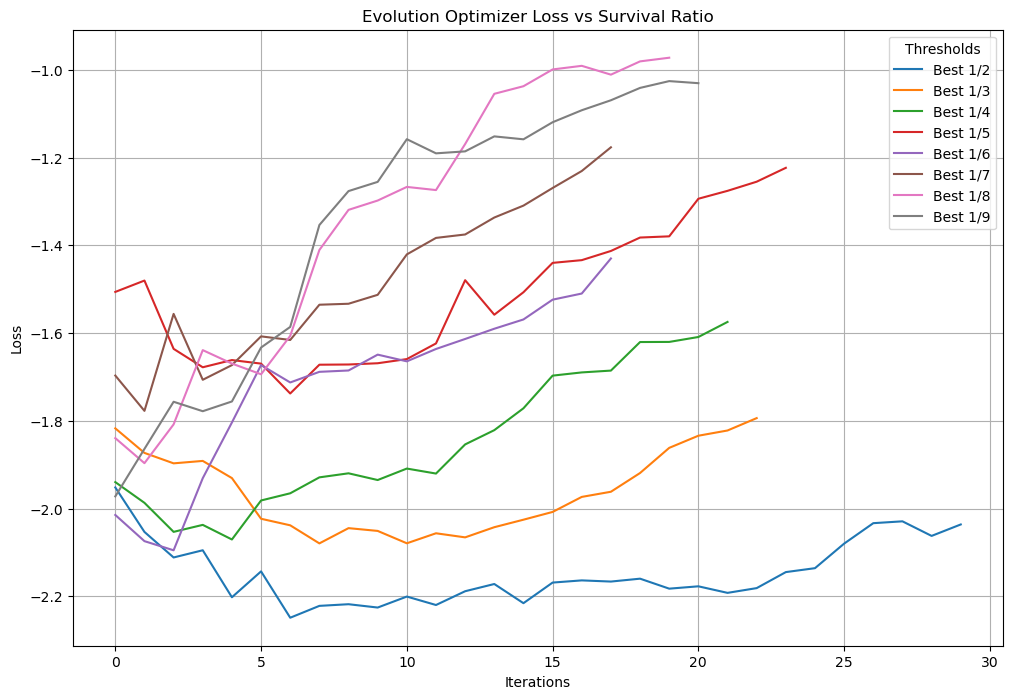

In [ ]:
thresh_range = range(2, 10)
loss_dict = {}

for thresh in thresh_range:
    print(f"Running for thresh = {thresh}")
    
    # Generate new data for fairness (or keep it fixed if you prefer)
    X, y = classification_data(p_dims=200, noise=0.8, n_points=100)
    
    # Set up model and optimizer
    LR = LogisticRegression()
    opt = FitnessOptimizer(LR)
    LR.set_optimizer(opt)
    opt.set_population_size(100)
    
    # Loss tracking
    loss = []
    start = time.time()
    
    # Optimization loop
    while accuracy(LR, X, y) < 1:
        opt.step(X, y, fitness_threshold=thresh)
        loss.append(LR.loss(X, y).item())
    
    print(f"Finished in {len(loss)} iterations, Time: {round(time.time() - start, 2)}s")
    loss_dict[thresh] = loss

# Plotting
plt.figure(figsize=(12, 8))
for k, loss in loss_dict.items():
    plt.plot(loss, label=f"Best 1/{k}")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Survival Ratio")
plt.legend(title="Thresholds")
plt.grid(True)
plt.show()
